Here we shall analyse stocks using Conv1d layer with window of 60 days and we shall do 10 days prediction. We shall follow the philosophy of WaveNet. Thanks to https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
# Imports

In [ ]:
import numpy as np
import pandas as pd
import keras
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import time

In [ ]:
df = pd.read_csv('data.csv',names=["id","uuid","date","type","value"])
df.head()

In [71]:
steps = df[df["type"] == 1].drop(columns=["type","id"])[:100000]

def convert_to_timestamp(x):
    """Convert date objects to integers"""
    return time.mktime(time.strptime(x, "%Y-%m-%d"))

# steps["value"] = MinMaxScaler().fit_transform(steps[["value"]])

def preprocess(x):
    x["value"] = MinMaxScaler().fit_transform(x[["value"]])
    x["date"] = x["date"].apply(convert_to_timestamp)
    x["date"] = MinMaxScaler().fit_transform(x[["date"]])
    return x
    
steps = steps.groupby('uuid').apply(preprocess,include_groups=False)[["value"]]
steps.head()

value
uuid                                                    
102b72d02aebae82c5c1ee3d4dcbc4d82de7c7ee 99819  0.231572
                                         99833  0.009491
                                         99843  0.473861
                                         99848  0.653592
                                         99851  0.340029

In [72]:
xtrain = []
ytrain = []
xtest=[]
ytest=[]
window=50
test_ratio=0.1
for uuid, group in steps.groupby('uuid'):
    split=int(len(group)*(1-test_ratio))
    if split<window:
        continue
        
    group = np.array(group.values)


    for i in range (window,split):
        xtrain.append(group[i-window:i])
        ytrain.append(group[i])

    for i in range (split,len(group)):
        xtest.append(group[i-window:i])
        ytest.append(group[i])

xtrain=np.array(xtrain)
ytrain=np.array(ytrain)
xtest=np.array(xtest)
ytest=np.array(ytest)

In [78]:
model = keras.models.Sequential()
model.add(keras.layers.Input(
    shape=xtrain[0].shape,
))
for rate in (1, 2, 4)*2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=4,
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss="mse", optimizer="adam")
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_41 (Conv1D)              │ (None, 47, 20)         │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 41, 20)         │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 29, 20)         │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_44 (Conv1D)              │ (None, 26, 20)         │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_45 (Conv1D)              │ (None, 20, 20)         │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_46 (Conv1D)              │ (None, 8, 20)          │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 7, 10)          │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,681 (33.91 KB)

 Trainable params: 8,681 (33.91 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
from keras.src.callbacks import EarlyStopping

history = model.fit(xtrain, ytrain, epochs=20, verbose=1, batch_size=32, validation_split=.2,callbacks=EarlyStopping(patience=5))

Epoch 1/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0320 - val_loss: 0.0289
Epoch 2/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0268 - val_loss: 0.0286
Epoch 3/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0272 - val_loss: 0.0285
Epoch 4/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0267 - val_loss: 0.0290
Epoch 5/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0268 - val_loss: 0.0283
Epoch 6/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0267 - val_loss: 0.0282
Epoch 7/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0265 - val_loss: 0.0286
Epoch 8/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0266 - val_loss: 0.0283
Epoch 9/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0267 - val_loss: 0.0290
Epoch 10/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0263 - val_loss: 0.0284
Epoch 11/20
1684/1684 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0263 - val_loss: 0.0283


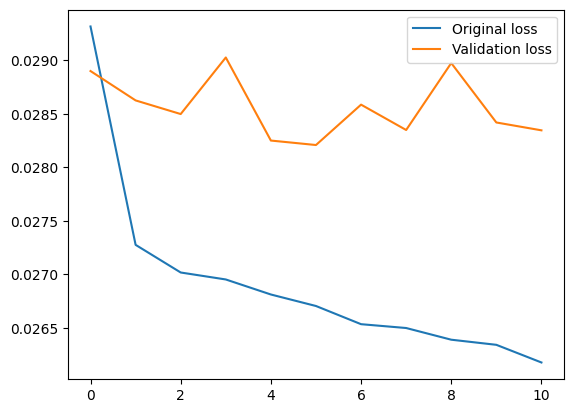

In [80]:
plt.plot(history.history['loss'], label='Original loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [81]:
model.evaluate(xtest, ytest, batch_size=32)

314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0262


0.02658708579838276

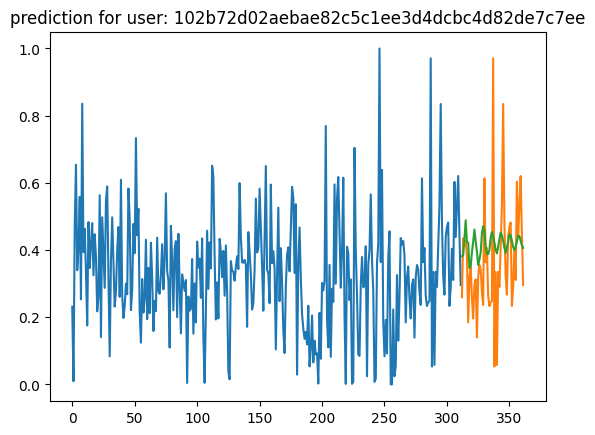

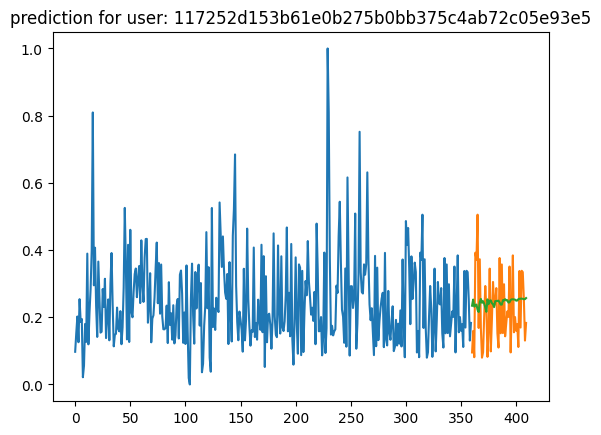

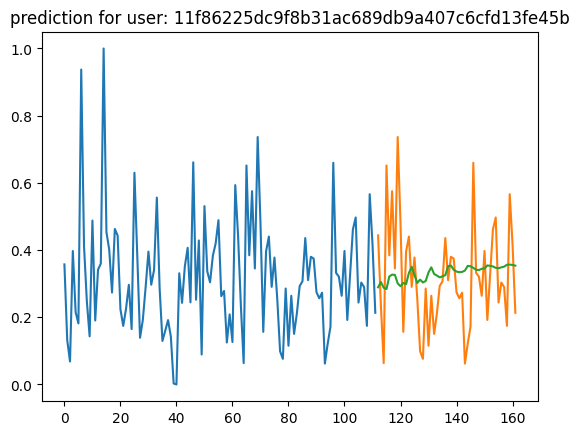

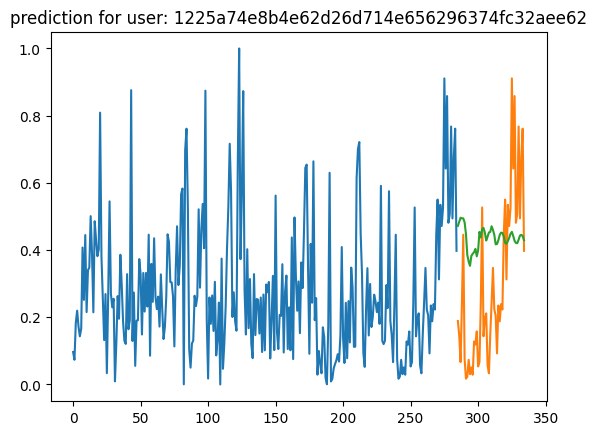

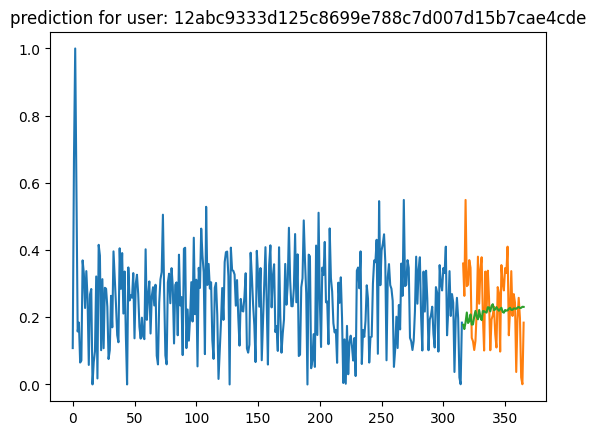

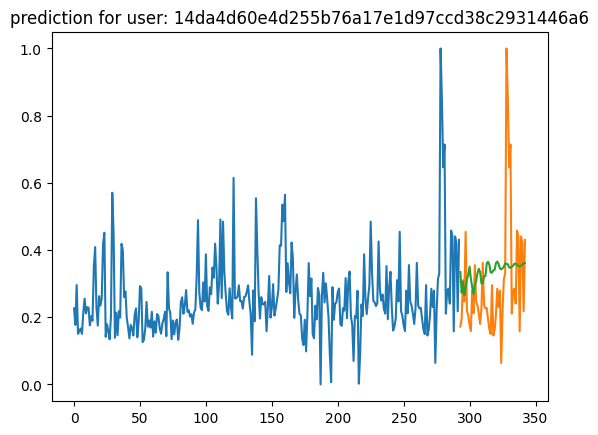

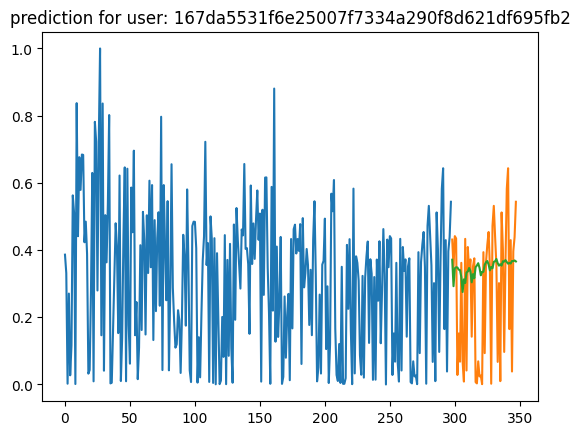

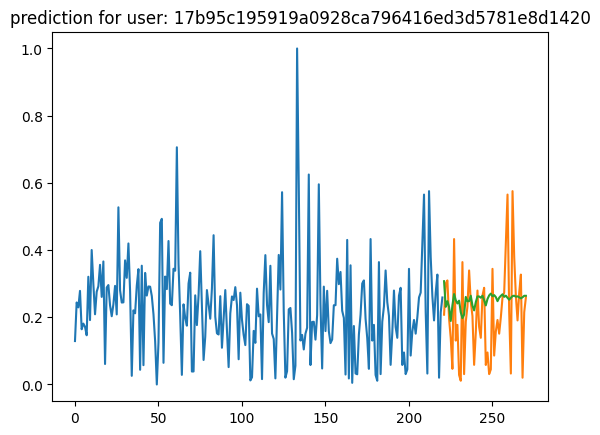

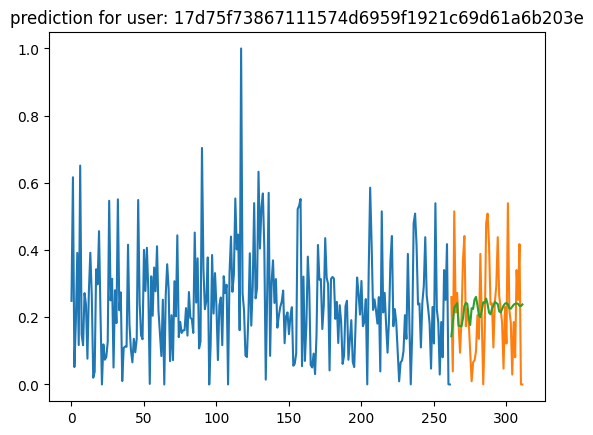

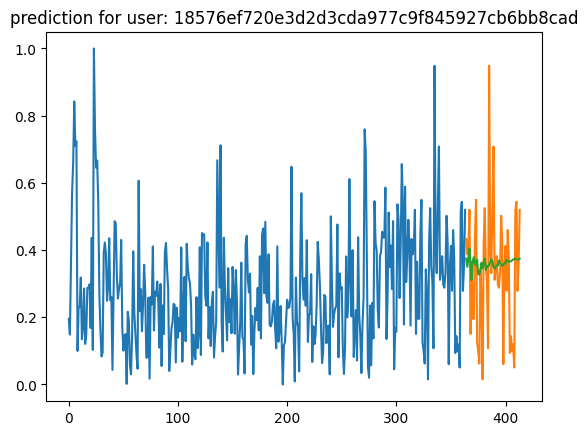

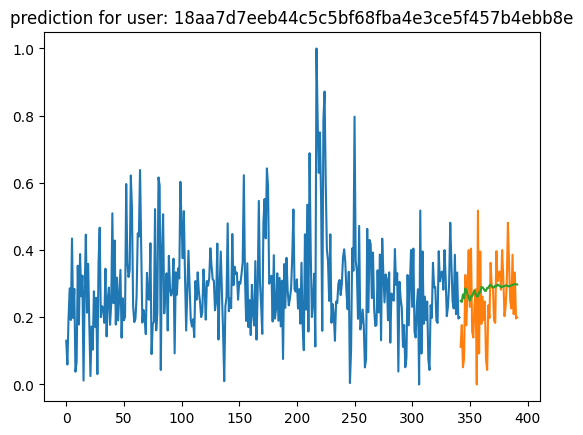

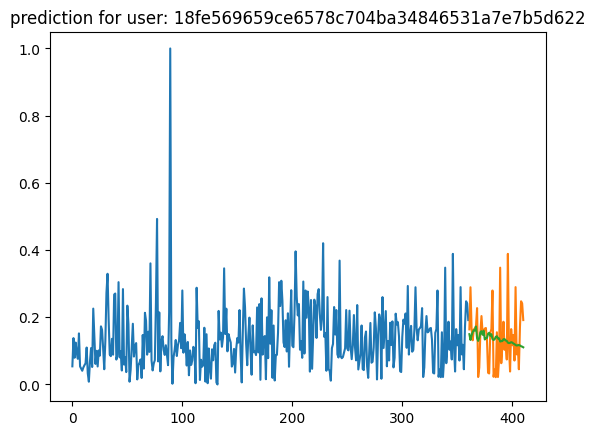

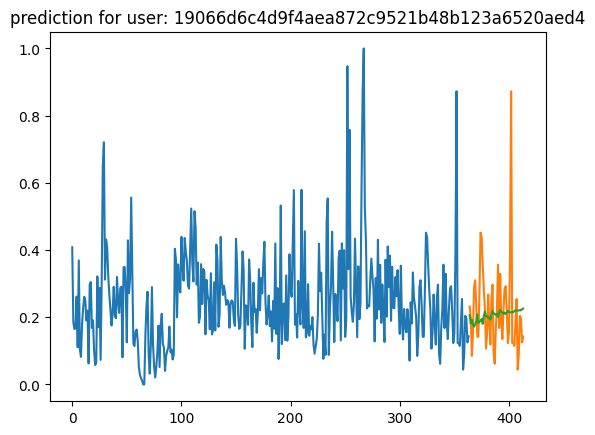

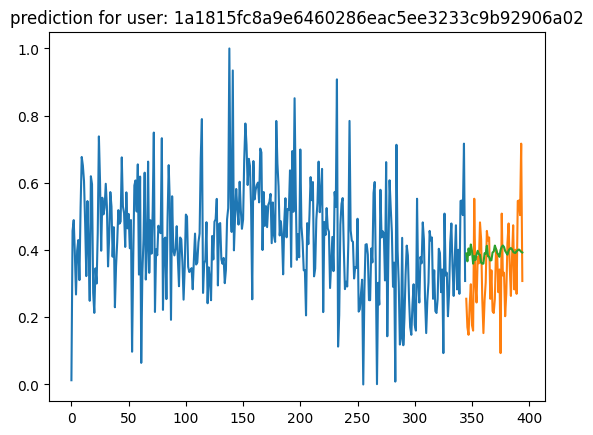

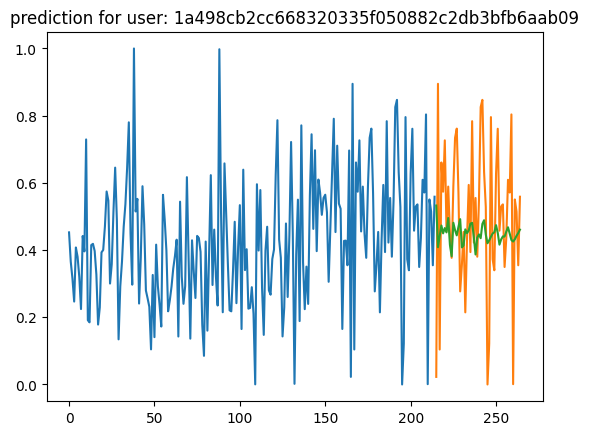

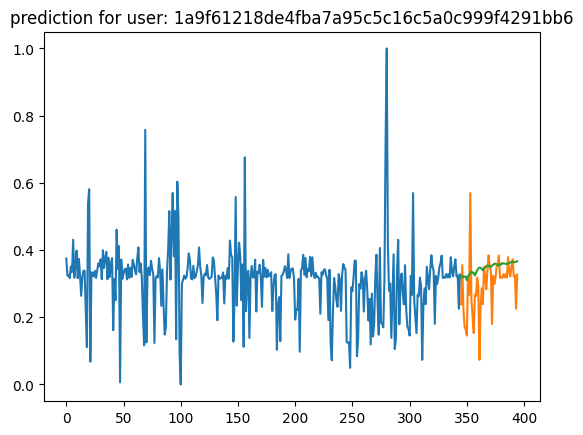

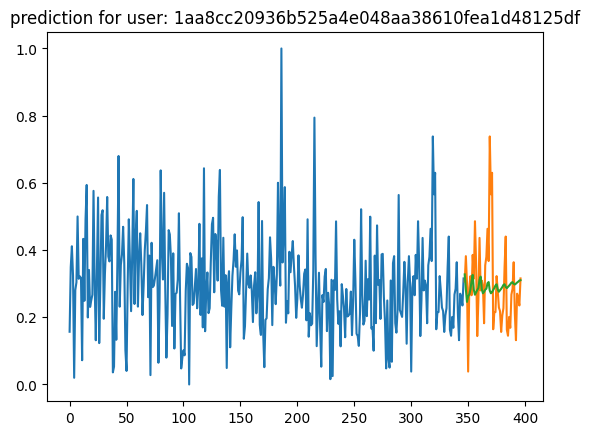

KeyboardInterrupt: 

In [83]:
for uuid,group in steps.groupby('uuid'):
    if len(group)<2*window:
        continue
    common = group.values
    actual=group[-window:].values
    pred=[]
    dati=common[-window:]
    for i in range(window):
        # new_date=dati[-1,1]+1/len(group)
        new_entry=[
            model.predict(np.array([dati]),verbose=0)[0][0]
            # new_date
        ]
        pred.append(new_entry)
        dati = np.concatenate((dati, [new_entry]))[-window:]
    pred=np.array(pred)
    plt.title("prediction for user: "+uuid)
    plt.plot([i for i in range(len(common))],common, label='Truth')
    plt.plot([i+len(common) for i in range(len(actual))],actual,label='Actual')
    plt.plot([i+len(common) for i in range(len(pred))],pred,label='Predicted')
    plt.show()
    plt.close()

In [61]:
model.save("./modello-passi.keras")

In [ ]:
model=keras.saving.load_model("./modello-passi.keras")